In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sb
from src import config
import os
import re
import statsmodels.api as sm
import numpy as np

sb.set_theme()

In [2]:
scores = pd.read_csv(
    os.path.join(config.DATASET_ROOT, config.FREESURFER_SYNTH_FOLDER, "scores.csv"),
    index_col=0,
)
scores

,subject,session,generation,motion_mm,motion_binary,identifier,data
0,sub-NDARDE827UF0,ses-HCP,gen-orig,0.000000,False,sub-NDARDE827UF0_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
1,sub-NDARDE827UF0,ses-HCP,gen-000,1.018878,True,sub-NDARDE827UF0_ses-HCP_gen-000,FS_SynthCortical_V2/sub-NDARDE827UF0/ses-HCP/g...
2,sub-NDARDE827UF0,ses-HCP,gen-001,0.950239,True,sub-NDARDE827UF0_ses-HCP_gen-001,FS_SynthCortical_V2/sub-NDARDE827UF0/ses-HCP/g...
3,sub-NDARDE827UF0,ses-HCP,gen-002,1.091439,True,sub-NDARDE827UF0_ses-HCP_gen-002,FS_SynthCortical_V2/sub-NDARDE827UF0/ses-HCP/g...
4,sub-NDARDE827UF0,ses-HCP,gen-003,0.070825,True,sub-NDARDE827UF0_ses-HCP_gen-003,FS_SynthCortical_V2/sub-NDARDE827UF0/ses-HCP/g...
...,...,...,...,...,...,...,...
2035,sub-NDARJE271DMC,ses-VNav,gen-045,1.809495,True,sub-NDARJE271DMC_ses-VNav_gen-045,FS_SynthCortical_V2/sub-NDARJE271DMC/ses-VNav/...
2036,sub-NDARJE271DMC,ses-VNav,gen-046,1.566372,True,sub-NDARJE271DMC_ses-VNav_gen-046,FS_SynthCortical_V2/sub-NDARJE271DMC/ses-VNav/...
2037,sub-NDARJE271DMC,ses-VNav,gen-047,0.214608,True,sub-NDARJE271DMC_ses-VNav_gen-047,FS_SynthCortical_V2/sub-NDARJE271DMC/ses-VNav/...
2038,sub-NDARJE271DMC,ses-VNav,gen-048,1.915437,True,sub-NDARJE271DMC_ses-VNav_gen-048,FS_SynthCortical_V2/sub-NDARJE271DMC/ses-VNav/...


In [3]:
path_pattern = os.path.join(
    config.DATASET_ROOT,
    config.FREESURFER_SYNTH_FOLDER,
    "derivatives",
    "sub-*",
    "ses-*",
    "gen-*",
    "stats",
)
sub_ses_gen = glob.glob(path_pattern)
rh_files = glob.glob(os.path.join(path_pattern, "rh.aparc.stats"))
lh_files = glob.glob(os.path.join(path_pattern, "lh.aparc.stats"))
len(sub_ses_gen), len(rh_files), len(lh_files)

(1020, 996, 996)

In [4]:
subject_list = pd.DataFrame(rh_files)
subject_list[0] = (
    subject_list[0]
    .str.removesuffix("/stats/rh.aparc.stats")
    .str.removeprefix("/home/at70870/local_scratch/FS_SynthCortical_V2/derivatives/")
)
subject_list.to_csv("subjects.csv")

In [5]:
def find_mean_thick(path: str):
    pattern = r"# Measure Cortex, MeanThickness, Mean Thickness, ([\d\.]*), mm"
    sub_ses_gen = path.split("/")[6:9]
    with open(path, "r") as file:
        for line in file:
            matches = re.match(pattern, line)
            if matches is not None:
                return *sub_ses_gen, float(matches.group(1))


rh_thick = pd.DataFrame(
    map(find_mean_thick, rh_files),
    columns=("subject", "session", "generation", "rh_thickness"),
)
lh_thick = pd.DataFrame(
    map(find_mean_thick, lh_files),
    columns=("subject", "session", "generation", "lh_thickness"),
)

thick_df = pd.merge(rh_thick, lh_thick, on=("subject", "session", "generation"))
full_df = pd.merge(thick_df, scores, on=("subject", "session", "generation"))
full_df[full_df["generation"] == "gen-orig"]

,subject,session,generation,rh_thickness,lh_thickness,motion_mm,motion_binary,identifier,data
15,sub-NDARNZ084JVC,ses-HCP,gen-orig,2.59660,2.69300,0.0,False,sub-NDARNZ084JVC_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
66,sub-NDARBV663TRE,ses-HCP,gen-orig,2.69727,2.71657,0.0,False,sub-NDARBV663TRE_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
114,sub-NDAREL410HHK,ses-VNav,gen-orig,2.54649,2.62446,0.0,False,sub-NDAREL410HHK_ses-VNav_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
162,sub-NDARWY718TY7,ses-VNav,gen-orig,2.94929,2.95133,0.0,False,sub-NDARWY718TY7_ses-VNav_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
210,sub-NDARGV455JV1,ses-HCP,gen-orig,2.72582,2.75643,0.0,False,sub-NDARGV455JV1_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
260,sub-NDARZP542LJK,ses-HCP,gen-orig,2.62766,2.61017,0.0,False,sub-NDARZP542LJK_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
310,sub-NDARVV095BWU,ses-HCP,gen-orig,3.01623,3.01838,0.0,False,sub-NDARVV095BWU_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
360,sub-NDARPY478YM0,ses-VNav,gen-orig,2.86808,2.90186,0.0,False,sub-NDARPY478YM0_ses-VNav_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
411,sub-NDARPE424GZZ,ses-HCP,gen-orig,2.70423,2.72296,0.0,False,sub-NDARPE424GZZ_ses-HCP_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...
462,sub-NDARUX408KJ1,ses-VNav,gen-orig,2.79438,2.79404,0.0,False,sub-NDARUX408KJ1_ses-VNav_gen-orig,/home/at70870/local_scratch/FS_SynthCortical_V...


In [6]:
subjects = full_df["subject"].unique()

for hem in ["rh", "lh"]:
    for sub in subjects:
        first_val = full_df.loc[
            (full_df["subject"] == sub) & (full_df["generation"] == "gen-orig"),
            f"{hem}_thickness",
        ]
        if len(first_val) == 1:
            full_df.loc[full_df["subject"] == sub, "first_val"] = first_val.item()

    full_df[f"loss_{hem}_percent"] = (
        100
        * (full_df[f"{hem}_thickness"] - full_df["first_val"])
        / full_df["first_val"]
    )
    full_df[f"loss_{hem}"] = full_df[f"{hem}_thickness"] - full_df["first_val"]
full_df

,subject,session,generation,rh_thickness,lh_thickness,motion_mm,motion_binary,identifier,data,first_val,loss_rh_percent,loss_rh,loss_lh_percent,loss_lh
0,sub-NDARNZ084JVC,ses-HCP,gen-005,2.62925,2.66698,0.758481,True,sub-NDARNZ084JVC_ses-HCP_gen-005,FS_SynthCortical_V2/sub-NDARNZ084JVC/ses-HCP/g...,2.69300,1.257414,0.03265,-0.966209,-0.02602
1,sub-NDARNZ084JVC,ses-HCP,gen-044,2.60397,2.57590,2.076983,True,sub-NDARNZ084JVC_ses-HCP_gen-044,FS_SynthCortical_V2/sub-NDARNZ084JVC/ses-HCP/g...,2.69300,0.283833,0.00737,-4.348310,-0.11710
2,sub-NDARNZ084JVC,ses-HCP,gen-024,2.62757,2.71135,0.285003,True,sub-NDARNZ084JVC_ses-HCP_gen-024,FS_SynthCortical_V2/sub-NDARNZ084JVC/ses-HCP/g...,2.69300,1.192714,0.03097,0.681396,0.01835
3,sub-NDARNZ084JVC,ses-HCP,gen-016,2.50597,2.48075,1.883787,True,sub-NDARNZ084JVC_ses-HCP_gen-016,FS_SynthCortical_V2/sub-NDARNZ084JVC/ses-HCP/g...,2.69300,-3.490334,-0.09063,-7.881545,-0.21225
4,sub-NDARNZ084JVC,ses-HCP,gen-048,2.67762,2.73839,0.785040,True,sub-NDARNZ084JVC_ses-HCP_gen-048,FS_SynthCortical_V2/sub-NDARNZ084JVC/ses-HCP/g...,2.69300,3.120234,0.08102,1.685481,0.04539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,sub-NDARFD316UD2,ses-VNav,gen-026,2.44197,2.39647,2.259420,True,sub-NDARFD316UD2_ses-VNav_gen-026,FS_SynthCortical_V2/sub-NDARFD316UD2/ses-VNav/...,2.71609,-8.295216,-0.22089,-11.767651,-0.31962
992,sub-NDARFD316UD2,ses-VNav,gen-004,2.06825,2.34999,2.299032,True,sub-NDARFD316UD2_ses-VNav_gen-004,FS_SynthCortical_V2/sub-NDARFD316UD2/ses-VNav/...,2.71609,-22.329751,-0.59461,-13.478935,-0.36610
993,sub-NDARFD316UD2,ses-VNav,gen-028,2.37318,2.39829,1.214358,True,sub-NDARFD316UD2_ses-VNav_gen-028,FS_SynthCortical_V2/sub-NDARFD316UD2/ses-VNav/...,2.71609,-10.878529,-0.28968,-11.700643,-0.31780
994,sub-NDARFD316UD2,ses-VNav,gen-011,2.30044,2.13249,1.650927,True,sub-NDARFD316UD2_ses-VNav_gen-011,FS_SynthCortical_V2/sub-NDARFD316UD2/ses-VNav/...,2.71609,-13.610179,-0.36242,-21.486770,-0.58360


<Axes: xlabel='motion_mm', ylabel='loss_lh_percent'>

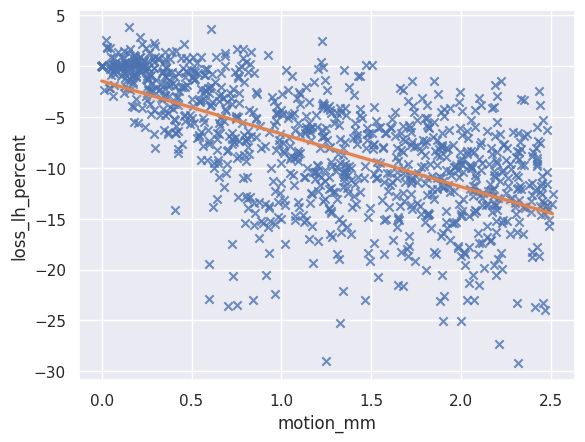

In [8]:
sb.regplot(
    full_df[full_df["loss_lh"].notna()],
    x="motion_mm",
    y="loss_lh_percent",
    line_kws={"color": "C1"},
    marker="x",
    ci=95,
)

In [12]:
est = sm.OLS(
    full_df[full_df["loss_lh"].notna()]["loss_lh_percent"],
    sm.add_constant(full_df[full_df["loss_lh"].notna()]["motion_mm"]),
)
est2 = est.fit()
print(type(est2))
print(est2.summary())

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:        loss_lh_percent   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     653.8
Date:                Thu, 30 Jan 2025   Prob (F-statistic):          3.14e-111
Time:                        13:06:42   Log-Likelihood:                -2959.2
No. Observations:                 996   AIC:                             5922.
Df Residuals:                     994   BIC:                             5932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

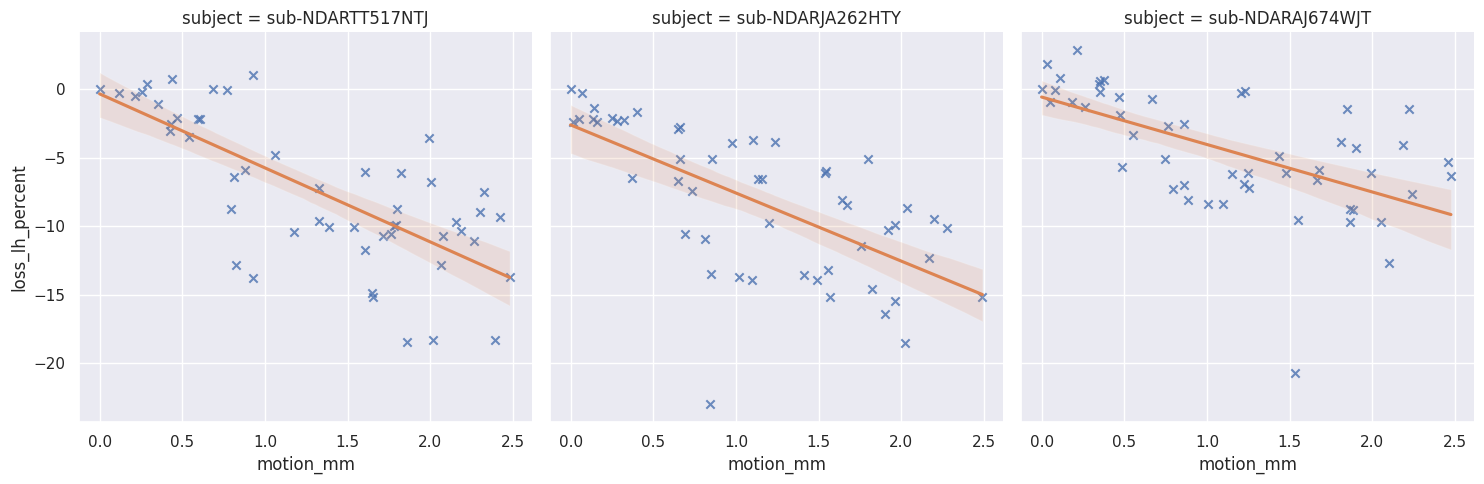

In [15]:
subjects = full_df["subject"].unique()[10:13]
subject = full_df[full_df["subject"].isin(subjects)]

sb.lmplot(
    subject,
    x="motion_mm",
    y="loss_lh_percent",
    line_kws={"color": "C1"},
    markers="x",
    col="subject",
)

In [22]:
for sub in full_df["subject"].unique():
    subject = full_df[full_df["subject"] == sub]
    est = sm.OLS(subject["loss_lh_percent"], sm.add_constant(subject["motion_mm"]))
    est2 = est.fit()
    print(type(est2))
    print(est2.summary())
    est2.rsquared, est2.f_pvalue, est2.params

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:        loss_lh_percent   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     101.4
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.43e-18
Time:                        13:12:17   Log-Likelihood:                -432.09
No. Observations:                 153   AIC:                             868.2
Df Residuals:                     151   BIC:                             874.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

(0.40183217403798543,
 1.4312707011840758e-18,
 const       -1.203497
 motion_mm   -4.612869
 dtype: float64)

In [34]:
to_process = glob.glob(
    os.path.join(
        config.DATASET_ROOT,
        config.FREESURFER_SYNTH_FOLDER,
        "derivatives",
        "sub-*",
        "ses-*",
        "gen-*",
    )
)
to_process = list(
    map(
        lambda x: x.removeprefix(
            f"{config.DATASET_ROOT}/{config.FREESURFER_SYNTH_FOLDER}/derivatives/"
        ),
        to_process,
    )
)
processed = glob.glob(
    os.path.join(
        config.DATASET_ROOT,
        config.FREESURFER_SYNTH_FOLDER,
        "derivatives",
        "sub-*",
        "ses-*",
        "gen-*",
        "stats",
        "rh.aparc.stats",
    )
)
processed = list(
    map(
        lambda x: x.removesuffix("/stats/rh.aparc.stats").removeprefix(
            f"{config.DATASET_ROOT}/{config.FREESURFER_SYNTH_FOLDER}/derivatives/"
        ),
        processed,
    )
)
unprocessed = set(to_process).difference(processed)

In [35]:
unprocessed = list(map(lambda x: x.split("/"), unprocessed))
unproc_df = pd.DataFrame(unprocessed, columns=["subject", "session", "generation"])
unproc_df

,subject,session,generation
0,sub-NDARFD316UD2,ses-VNav,gen-007
1,sub-NDARWE818UA6,ses-VNav,gen-017
2,sub-NDARWE818UA6,ses-VNav,gen-003
3,sub-NDARMA390CHB,ses-VNav,gen-005
4,sub-NDARFD316UD2,ses-VNav,gen-019
5,sub-NDARWE818UA6,ses-VNav,gen-011
6,sub-NDAREL410HHK,ses-VNav,gen-048
7,sub-NDARMA390CHB,ses-VNav,gen-022
8,sub-NDARFD316UD2,ses-VNav,gen-041
9,sub-NDARWY718TY7,ses-VNav,gen-022


In [17]:
unproc_df.to_csv("synth_fs_to_proc.csv")